# Fake News Identifer

Fake news runs rampant in today's society, and in the age of artificial intelligence, it can be difficult to separate what is real from what is false. However, we can use the power of data and machine learning to assess whether news is authentic or not, which is what this project attempts to accomplish.

## Setup

### Step 1: Connect to Kaggle, Download the Dataset

The dataset being used has three columns (not including the index): A title of a news report, the content of the report, and a truth value; '0' indicates fake news and '1' indicates real news. 

In [ ]:
!pip3 install kaggle -q kagglehub
!kaggle datasets download -d saurabhshahane/fake-news-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
100%|█████████████████████████████████████▉| 92.0M/92.1M [00:03<00:00, 30.5MB/s]
100%|██████████████████████████████████████| 92.1M/92.1M [00:03<00:00, 26.3MB/s]


### Step 2: Verify the Dataset

In [4]:
import zipfile
import pandas as pd

with zipfile.ZipFile('fake-news-classification.zip', 'r') as zip_file:
  zip_file.extractall('data')

!ls data

df = pd.read_csv('data/WELFake_Dataset.csv')
df.head()

WELFake_Dataset.csv cleaned_data.csv


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


We can see that the dataset is accessible, so now we can move onto the data preprocessing.

## Data Preprocessing

Since this dataset is entirely categorical (with the exception of the assessment of whether or not the news is real or fake), there is no need to address outliers. Instead, we will check how many missing values exist to ensure that we do not end up changing a large portion of the dataset.

In [5]:
duplicate_count = df.duplicated().sum()
print(f'Dataset has {duplicate_count} duplicate entries')
for column in df.columns:
    missing_count = df[column].isnull().sum()
    print(f'Column "{column}" has {missing_count} missing values')

Dataset has 0 duplicate entries
Column "Unnamed: 0" has 0 missing values
Column "title" has 558 missing values
Column "text" has 39 missing values
Column "label" has 0 missing values


There are 78,098 data entries in the dataset, so up to only 0.76% (597 out of 78,098) of the entries have missing values. As such, we can feel comfortable simply dropping any entries that contain a missing value.

In [8]:
df = df.dropna()
df.to_csv('data/cleaned_data.csv', index=False)
print('Cleaned data saved to cleaned_data.csv')

Cleaned data saved to cleaned_data.csv


Next, we will combine the titles and texts of the news reports into one feature. This can help us to identify inconsistencies between them and train our model more easily.

In [ ]:
df['report'] = df['title'] + ' ' + df['text']
df.head()
df.to_csv('data/cleaned_data.csv', index=False)

,Unnamed: 0,title,text,label,report
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...


Finally, because we are only analyzing the word content of these reports, we want to simplify the text as much as possible. This means removing things like special characters and numbers, as well as excess whitespace. Also, we will make all the text lowercase to avoid inconsistencies between identical words that are formatted differently.

In [13]:
import re

def clean_news_report(text):
    text = re.sub(r'\W', ' ', text) # remove special characters
    text = re.sub(r'\s+', ' ', text) # remove excess whitespace
    text = text.lower()
    return text

df['report'] = df['report'].apply(clean_news_report)
print('News report text cleaning completed')

News report text cleaning completed


The preprocessing is completed, and we can move onto the analysis phase.

## Data Analysis and Visualization

Identifying trends is especially difficult with data that is predominantly categorical, as this dataset is. We cannot simply find the correlation between two columns of the dataset. Instead, we will have to analyze specific features of the title and content of the news reports to see if there are features that are more indicative of fake news than others.

The first thing we can do is simply identify what proportion of the entries are fake news versus real:

In [26]:
fake_count = 0
real_count = 0
for __, row in df.iterrows():
    if row['label'] == 0:
        fake_count += 1
    elif row['label'] == 1:
        real_count += 1

print(f'Number of real reports: {real_count}')
print(f'Number of fake reports: {fake_count}')
print(f'Calculated total entries: {real_count + fake_count}')
print(f'Actual entry count: {len(df)}')

Number of real reports: 36509
Number of fake reports: 35028
Calculated total entries: 71537
Actual entry count: 71537


This confirms that every report in the dataset is marked as either 'true' (1) or 'false' (0). These counts make up the following graph:

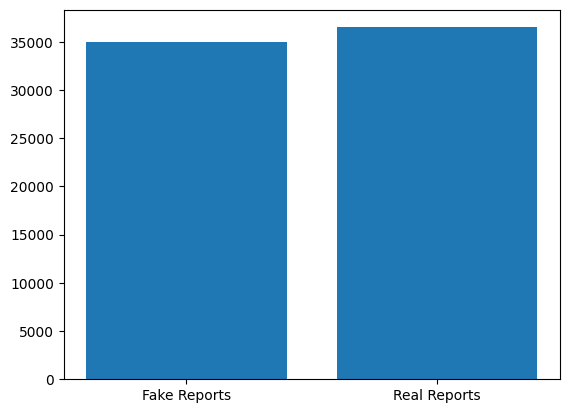

In [29]:
import matplotlib.pyplot as plt

plt.bar(['Fake Reports', 'Real Reports'], [fake_count, real_count])
plt.show()

As we can see, the distribution is nearly evenly split. This is good, as the model will not overfit for either one of the two potential outcomes.

## Building the Model

In order to create a predictive model, we will need to assign some kind of numerical significance to each entry in the dataset. We can do this by using Term Frequency-Inverse Document Frequency, where we will consider words that appear more commonly in the entries to be less significant to its meaning. This makes sense in the case of this dataset, as a word that appears across most of the entries would appear to not have much of an impact on whether or not the report was fake or real.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000) # Limit the model to 5000 "important" words (this value is arbitrary)
X = tfidf.fit_transform(df['report']).toarray()
y = df['label']

To effectively use the data to build the model, we will need to split the data into training and test sets. As the names suggest, the training set will train the model, while the test set will test to make sure the model works as intended.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we will build the model.

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Evaluating the Model

Now that the model is built and tested, we will evaluate how it performed in its tests.

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 0.9476516634050881
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      7081
           1       0.94      0.95      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308

Confusion Matrix:
 [[6669  412]
 [ 337 6890]]


As shown in the above output, the model has a 94.77% accuracy rating for the test set, based on the training from the training set. To be even more specific, there is a precision score of 0.94-0.95 for both classifications, which means that approximately 0.95 of the predicted positives are correct. This remains the same for the recall score, which describes how many actual positives are identified correctly by the model. Finally, the confusion matrix shows how many true positives/negatives were identified, as well as how many false positive/negatives. All of these metrics show that the model was quite successful in identifying fake news. 